In [14]:
import numpy as np
from kernels import *
import random
import matplotlib.pyplot as plt
import optax
import jax
import jax.numpy as jnp
from kernel_matrix import Kernel_matrix
from jax import vmap
import pandas as pd
from jax import random

np.random.seed(0)


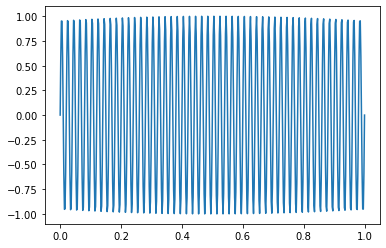

In [12]:

# set frequency of the sine wave 
k = 100
np_train_x = np.random.rand(2*k) * 0.5
np_train_y = np.sin(k * np.pi * np_train_x)
np_train_y = np_train_y + np.random.normal(scale=0.1, size=np_train_y.shape)

np_test_x = np.linspace(0, 1, 5*k)
np_test_y = np.sin(k * np.pi * np_test_x)

# reshape the data to (-1,1)
X_train= np_train_x.reshape(-1, 1)
y_train = np_train_y.reshape(-1, 1)
X_test = np_test_x.reshape(-1, 1)
y_test = np_test_y.reshape(-1, 1)

np.random.seed(0)
# plot the sine wave
plt.plot(np_test_x, np_test_y, label='sin(x)')

M = 20
X_col = np.min(X_test, 0) + (np.max(X_test, 0) - np.min(X_test, 0)) * (np.linspace(0, 1, num=M)).reshape((-1, 1))



In [13]:

class GPRLatent:

    def __init__(self, X, y, X_col, jitter, X_test, Y_test):
        self.X = X
        self.y = y
        self.X_col = X_col # X_col (ode collocation )
        self.jitter = jitter
        self.X_con = np.concatenate((X, X_col), axis=0) # X_con = X (llk) + X_col (ode collocation )
        self.N = self.X.shape[0]
        self.N_col = self.X_col.shape[0]
        self.N_con = self.X_con.shape[0]
        self.K = RBF_kernel_u_1d()
        self.optimizer = optax.adam(0.005)
        self.kernel_matrix = Kernel_matrix(self.jitter, self.K, "Pendulum")
        self.X_test = X_test
        self.Y_test = Y_test

    def KL_term(self, mu, L, K):
        Ltril = jnp.tril(L)
        # hh_expt = jnp.matmul(Ltril, Ltril.T) + jnp.matmul(mu, mu.T)
        hh_expt = jnp.matmul(Ltril, Ltril.T)
        kl = (0.5 * jnp.trace(jnp.linalg.solve(K, hh_expt)) + 0.5 * jnp.linalg.slogdet(K)[1] - 0.5 * jnp.sum(jnp.log(jnp.square(jnp.diag(Ltril)))))
        return kl

    @partial(jit, static_argnums=(0,))
    def loss(self, params, key):
        ls = params['ls']
        mu = params['mu']
        L1 = params['L1']
        L2 = params['L2']
        log_v = params['log_v']
        log_tau = params['log_tau']
        x_p = jnp.tile(self.X_con.flatten(), (self.N_con, 1)).T
        X1_p = x_p.flatten()
        X2_p = jnp.transpose(x_p).flatten()
        K = self.kernel_matrix.get_kernel_matrx(X1_p, X2_p, jnp.exp(ls))
        A = jnp.linalg.cholesky(K)
        V = jnp.diag(jnp.exp(L1.reshape(-1))) + jnp.matmul(L2, L2.T)
        V_cho = jnp.linalg.cholesky(V)
        eta = mu + jnp.matmul(V_cho, jax.random.normal(key, shape=(self.N_con * 2, 1)))
        f = jnp.matmul(A, eta)
        kl = self.KL_term(mu, V_cho, jnp.eye(self.N_con * 2))
        elbo = -kl + 0.5 * self.N * log_tau - 0.5 * jnp.exp(log_tau) * jnp.sum(jnp.square(f[:self.N].reshape(-1) - self.y.reshape(-1))) + 0.5 * self.N_col * log_v - 0.5 * jnp.exp(log_v) * jnp.sum(
            jnp.square(f[(self.N_con + self.N):2 * self.N_con].reshape(-1) + jnp.sin(f[self.N:self.N_con]).reshape(-1)))
        return (-elbo).sum()

    @partial(jit, static_argnums=(0,))
    def step(self, params, opt_state, key):
        loss, d_params = jax.value_and_grad(self.loss)(params, key)
        updates, opt_state = self.optimizer.update(d_params, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss

    @partial(jit, static_argnums=(0,))
    def preds(self, params, Xte):
        ls = params['ls']
        mu = params['mu']
        L1 = params['L1']
        L2 = params['L2']
        x_p = jnp.tile(self.X_con.flatten(), (self.N_con, 1)).T
        X1_p = x_p.flatten()
        X2_p = jnp.transpose(x_p).flatten()
        K = self.kernel_matrix.get_kernel_matrx(X1_p, X2_p, jnp.exp(ls))
        A = jnp.linalg.cholesky(K)
        eta = mu
        f = jnp.matmul(A, eta)
        N_te = Xte.shape[0]
        x_p11 = jnp.tile(Xte.flatten(), (self.N_con, 1)).T
        x_p22 = jnp.tile(self.X_con.flatten(), (N_te, 1)).T
        X1_p2 = x_p11.flatten()
        X2_p2 = jnp.transpose(x_p22).flatten()
        K_u = vmap(self.K.kappa, (0, 0, None))(X1_p2.flatten(), X2_p2.flatten(), jnp.exp(ls)).reshape(N_te, self.N_con)
        K_u_tt = vmap(self.K.DD_y1_kappa, (0, 0, None))(X1_p2.flatten(), X2_p2.flatten(), jnp.exp(ls)).reshape(N_te, self.N_con)
        temp = jnp.concatenate((K_u, K_u_tt), axis=1)
        preds = jnp.matmul(temp, jnp.linalg.solve(K, f))
        K_cho = jnp.linalg.cholesky(K)
        V = jnp.diag(jnp.exp(L1.reshape(-1))) + jnp.matmul(L2, L2.T)
        V_cho = jnp.linalg.cholesky(V)
        temp1 = jnp.linalg.solve(K_cho.T, V_cho)
        temp2 = jnp.matmul(temp1, temp1.T)
        pred_stds = (1 + self.jitter - (temp * jnp.linalg.solve(K, temp.T).T).sum(1) + (temp * jnp.matmul(temp2, temp.T).T).sum(1))
        return preds, pred_stds**0.5

    def train(self, iter):
        key = jax.random.PRNGKey(0)
        params = {
            "ls": np.array([0.0]),
            "log_v": np.array([0.0]),
            "log_tau": np.array([0.0]),
            "mu": np.zeros((self.N_con * 2, 1)),
            "L1": 5 * np.ones((self.N_con * 2, 1)),
            "L2": 5 * np.ones((self.N_con * 2, self.N_con * 2)),
        }
        opt_state = self.optimizer.init(params)
        min_err = 2.0
        for i in range(iter):
            key, sub_key = jax.random.split(key)
            params, opt_state, loss = self.step(params, opt_state, sub_key)
            if i % 10 == 0 or i >= 15000:
                preds, pred_stds = self.preds(params, self.X_test)
                err = jnp.sqrt(jnp.mean(jnp.square(preds.reshape((-1, 1)) - self.Y_test.reshape((-1, 1)))))
                if (err < min_err):
                    min_err = err
                    print("It ", i, "Found min RMSE ", err)
                    plt.plot(self.X_test, self.Y_test)
                    plt.plot(self.X_test, preds)
                    plt.plot(self.X_test, preds.reshape(-1) - pred_stds.reshape(-1), linewidth=.3)
                    plt.plot(self.X_test, preds.reshape(-1) + pred_stds.reshape(-1), linewidth=.3)
                    plt.legend(["True solution", "PIGP"], prop={"size": 15})
                    plt.savefig("no_damping")
                    plt.clf()